In [51]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [52]:
%reload_ext autoreload
%autoreload 2

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW11


---
__Name:__  Nina Kuklisova 
__Class:__ MIDS w261 (Section 2)     
__Email:__  NKuklisova@iSchool.Berkeley.edu     
__Week:__   11

# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    HW11.0.  [Broadcast versus Caching in Spark ](#HW11.0)    
    HW11.1.  [HW11.2 Gradient descent](#HW11.1)   
    HW11.2.  [Gradient descent](#HW11.2)    
    HW11.3.  [Logistic Regression](#HW11.3)    
    HW11.4.  [SVMs](#HW11.4)  
    HW11.5.  [OPTIONAL  Distributed Perceptron algorithm](#HW11.5)  
    HW11.6.  [OPTIONAL  Evalution of perceptron algorihtms on PennTreeBank POS corpus](#HW11.6)  
    HW11.7.  [OPTIONAL Kernal Adatron](#HW11.7)
   
    HW11.8.  [OPTIONAL Create an animation of gradient descent for the Perceptron](#HW11.8)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #11

Version 2016-07-27 (FINAL)


 === INSTRUCTIONS for SUBMISSIONS ===
Follow the instructions for submissions carefully.

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 


=== IMPORTANT ===

TYPE-2 Fun option: Submit HW11 using a Zeppelin notebook (See Live slides for install instructions)

TYPE-1.5 Fun option: Complete HW11.8 only (no need to complete the rest of the questions)

HW11 can be completed locally on your computer
### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. (Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))

<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<a name="HW11.0"></a><h2 style="color:darkblue"> HW11.0: Broadcast versus Caching in Spark </h2>
[Back to Table of Contents](#TOC)


HW11.0  

Q: __What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.__

Brodcasting is the process in which the Master assigns the tasks to the worker nodes, caching is the process in which we use the memory.

In [ ]:
def logisticReg_GD_Spark(data,y,w=None,eta=0.05,iter_num=500,regPara=0.01, stopCriteria=0.0001,reg="Ridge"):
#eta learning rate
#regPara
dataRDD = sc.parallelize(np.append(y[:,None],data,axis=1)).cache() if w is None:
w = np.random.normal(size=data.shape[1]+1)
for i in range(iter_num):
w_broadcast = sc.broadcast(w)
g = dataRDD.map(lambda x: −x[0]*{1−1/(1+np.exp(−x[0] *np.dot(w_broadcast.value,np.append(x[1:],1))))) \ *np.append(x[1:],1)).reduce[lambda x,y:x+y)/data.shape[0]
# Gradient of logloss
if reg == "Ridge":
wreg = w*1
wreg[−1] = 0 #last value of weight vector is bias term;
ignore in regularization
elif reg == "Lasso":
wreg = w*1
wreg[−1] = 0 #last value of weight vector is bias term;
ignore in regularization
wreg = (wreg>0).astype(int)*2−1
else:
wreg = np.zeros(w.shape[0])
wdelta = eta*(g+regPara*wreg) #gradient: hinge loss + regularized term if sum(abs(wdelta))stopCriteria*sum(abs(w)): # converged as updates
to weight vector are small
break
w = w − wdelta
return w

Q: __Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb

(Similarly to the last exercise of the previous homework,) the main change that can be done to this notebook in order to make this code more efficient is using the broadcasting.

Q: __Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes: __

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb



In [1]:
## Set up Spark

import os
import sys 
import pyspark
from pyspark.sql import SQLContext

# We can give a name to our app (to find it in Spark WebUI) and configure execution mode
# In this case, it is local multicore execution with "local[*]"
app_name = "example-logs"
master = "local[*]"
conf = pyspark.SparkConf().setAppName(app_name).setMaster(master)
sc = pyspark.SparkContext(conf=conf)
sqlContext = SQLContext(sc)
print sc
print sqlContext

In [2]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

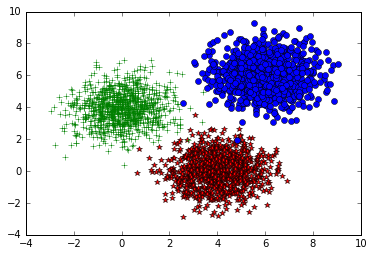

In [3]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [4]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

/usr/local/spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


Iteration0
[[ 0.812865    0.54864119]
 [ 3.9500721   2.65695476]
 [ 2.26534331  5.79479567]]


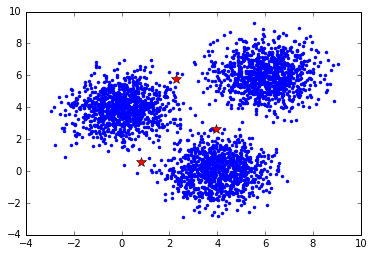

Iteration1
[[ 1.21060738  1.28222235]
 [ 5.13719868  2.19234191]
 [ 2.84288094  5.56449581]]


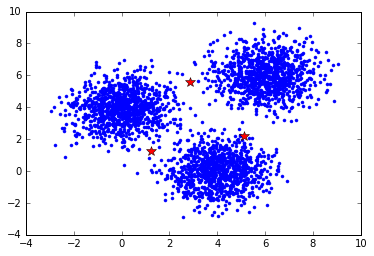

Iteration2
[[ 0.89650381  2.02236766]
 [ 5.17396581  1.56643536]
 [ 3.83804743  5.85961236]]


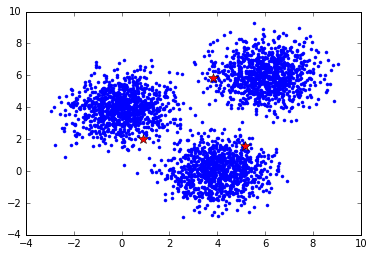

Iteration3
[[ 0.17656685  3.3450882 ]
 [ 4.34704752  0.17882981]
 [ 5.52596675  6.04592115]]


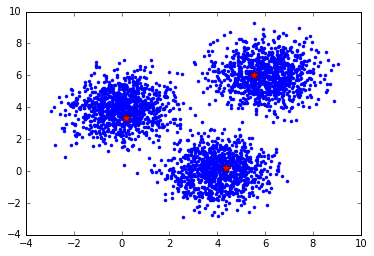

Iteration4
[[  2.49396469e-03   3.91661318e+00]
 [  4.01661539e+00   1.33261243e-02]
 [  5.99137132e+00   6.01950475e+00]]


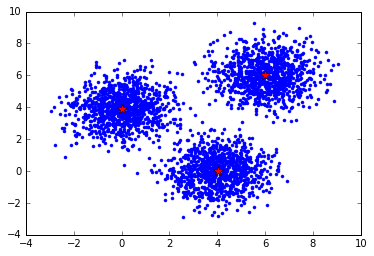

Iteration5
[[  3.32974504e-03   3.93033160e+00]
 [  4.00755268e+00   1.26459689e-02]
 [  5.99756425e+00   6.01635909e+00]]


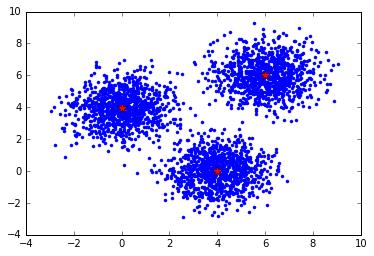

Final Results:
[[  3.32974504e-03   3.93033160e+00]
 [  4.00755268e+00   1.26459689e-02]
 [  5.99756425e+00   6.01635909e+00]]


In [5]:
from pyspark.mllib.clustering import KMeans, KMeansModel

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("data.csv") #.cache()
parsedData = D.map(lambda line: np.array([float(x) for x in line.split(',')]))
featureLen = len(parsedData.take(1)[0])-1
n = parsedData.count()
learningRate=0.05
w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
wBroadcast = sc.broadcast(w)   #make available in memory as read-only to the executors (for mappers and reducers)

iter_num = 0

def error(point):
    center = clusters.centers[clusters.predict(point)]
    return np.sqrt(sum([x**2 for x in (point - center)]))

clusters = KMeans.train(parsedData, 2, maxIterations=10, runs=10, initializationMode="random")

for i in range(10):  
    wBroadcast = sc.broadcast(w)   #make available in memory as read-only to the executors (for mappers and reducers)

    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
    w = w - learningRate/n
    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    #print("Within Set Sum of Squared Error = " + str(WSSSE))
print "Final Results:"
print centroids

<a name="HW11.1"> <h2 style="color:darkgreen">HW11.1 Loss Functions</h2>
[Back to Table of Contents](#TOC)

 
Q: __In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm? __

In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.

For soft margin SVM, the loss term is

$ \begin{eqnarray*}
J( \mathcal{w} ) &= \frac{1}{2} ||w||^2 + \sum_{i} max (0, 1 - y^i w^T x^i) \\
&= \frac{1}{2} ||w||^2 + \sum_{i} max (0, 1 - y^i w^T x^i) \\
&= R_2(w) + \sum_{i} L_{hinge} (m_i)
\end{eqnarray*} $

while an L2 penalized logistic regression learning algorithm has its log loss defined as

$ \begin{equation*}
J( \mathcal{w} ) = \lambda ||w||^2 + \sum_{i} log (1 + e^{-y^{(i)} f_w( x^{(i)})

\end{equation*} $

where we defined

$ \begin{eqnarray*}
L(m) = log 1 + e^{-m} \\

m^{i} = y^{(i)} f_w (x^{(i)} ) \\

y^{(i)} = \begin{cases} 
-1 &, \mathrm{if} y^{(i)} = 0 \\
1 &, \mathrm{if} y^{(i)} = 1
\end{cases}

\end{eqnarray*} $ .

Therefore, as both are trying to minimize a different loss term, they can yield different results.

In the context of a binary classification problem, a hyperplane is the decision surface for both a linear SVM and logistic regression. A linear SVM tries to fit a hyperplane that separate the data that lie on one side of it, and also tries to choose it so that the margin between the two classes is maximal. On the other hand, logistic regression uses the data points as if they were along a continuous sigmoid function, and the separating hyperplane surface is where the probability of one of the two classes is higher than the threshold probability (in most cases set to 0.5).

Q: __In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm? __

The perceptron loss function is similar to the hinge loss function of linear SVM; so, in some cases, the two may yield the same results. Whether of not this is the case depends on whether or not the two classes are linearly separable. If they are not, then neither converges, and the result is the same. If they are, they can yield different results, because the perceptron learning algorithm finishes once it finds a hyperplane that separates the data points in two classes, while linear SVM will still try to maximize the margin.

[OPTIONAL]: generate an artifical binary classification dataset with 2 input features and plot the learnt separating surface for both a linear SVM and for  logistic regression. Comment on the learnt surfaces. Please feel free to do this in Python (no need to use Spark).

<a name="HW11.2"><h2 style="color:darkgreen">HW11.2 Gradient descent</h2>
[Back to Table of Contents](#TOC)

Q: __In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?__

There are 3 main flavors of penalized loss functions in the context of logistic regression.

(1) Hinge loss:
$ max \{ 0, 1 - y \bf{w}^T \bf{x} \},~~~~ y \in \{ -1, +1 \} $

(2) Logistic loss:
$ log(1 + exp(-y \bf{w} ^T \bf{x} ) ), ~~~~ y \in \{ -1, +1 \} $

(3) Squared loss:
$ \frac{1}{2} ( \bf{w}^T \bf{x} - y)^2, ~~~~y \in \mathbb{R} $

and 3 regularizers:

(1) L1:  $|| \bf{w} ||_1 $

(2) L2:  $\frac{1}{2}|| \bf{w} ||_2^2 $

(3) elastic net: $ \alpha || \bf{w} ||_1 + (1 - \alpha) \frac{1}{2}|| \bf{w} ||_2^2 $

and all of them are supported by Spark MLlib, as described in its documentation:
https://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions

Q: __Describe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details) __



As explained in the class reading for week 11 in Andrew Ng's lecture notes, the L2 penalty maximizes the maximum likelihood estimation for a Gaussian distribution. Similarly, the L1 norm does this for a Laplace distribution. Therefore, we L1 corresponds to a Laplace prior, while L2 corresponds to a Gaussian prior.

<a name="HW11.3"> <h2 style="color:darkblue"> HW11.3 Logistic Regression</h2>
[Back to Table of Contents](#TOC)

Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.

```python
def generateData(n):
 """ 
  generates a 2D linearly separable dataset with n samples. 
  The third element of the sample is the label
 """
 xb = (rand(n)*2-1)/2-0.5
 yb = (rand(n)*2-1)/2+0.5
 xr = (rand(n)*2-1)/2+0.5
 yr = (rand(n)*2-1)/2-0.5
 inputs = []
 for i in range(len(xb)):
  inputs.append([xb[i],yb[i],1])
  inputs.append([xr[i],yr[i],-1])
 return inputs

```
Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

>weight(X)= 1/||X||, 

>where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

>Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

In [6]:
from numpy.random import rand

def generateData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (rand(n)*2-1)/2-0.5
    yb = (rand(n)*2-1)/2+0.5
    xr = (rand(n)*2-1)/2+0.5
    yr = (rand(n)*2-1)/2-0.5
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs

In [7]:
# Generate the data

training = np.array(generateData(100))
testing = np.array(generateData(100))

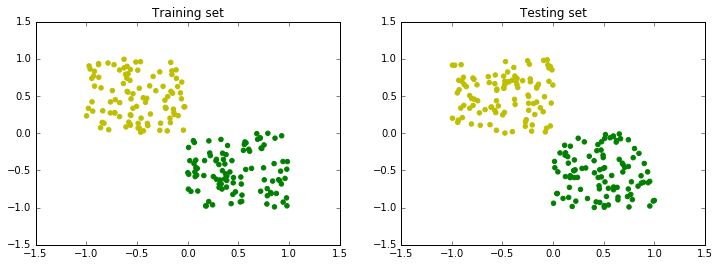

In [8]:
# Plot the data

import matplotlib.pyplot as plt

def plot_data(dataset):
    colors = ['y' if x ==1 else 'g' for x in dataset[:, 2]]
    plt.scatter( dataset[:, 0], dataset[:, 1], color = colors)

fig = plt.gcf()
fig.set_size_inches(12, 4)

plt.subplot(1, 2, 1)
plt.title('Training set')
plot_data(training)

plt.subplot(1, 2, 2)
plt.title('Testing set')
plot_data(testing)

Q: __Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. __

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

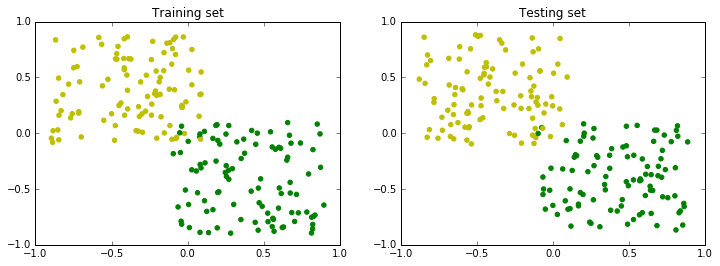

In [9]:
# we make these two overlap

def generateData_m(n):
    """ 
    generates a 2D dataset with n samples. 
    The third element of the sample is the label
    """
    xb = (rand(n)*2-1)/2-0.4
    yb = (rand(n)*2-1)/2+0.4
    xr = (rand(n)*2-1)/2+0.4
    yr = (rand(n)*2-1)/2-0.4
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i],1])
        inputs.append([xr[i],yr[i],-1])
    return inputs


# Generate the data

training_m = np.array(generateData_m(100))
testing_m = np.array(generateData_m(100))

fig = plt.gcf()
fig.set_size_inches(12, 4)

plt.subplot(1, 2, 1)
plt.title('Training set')
plot_data(training_m)

plt.subplot(1, 2, 2)
plt.title('Testing set')
plot_data(testing_m)

Q: __ Using MLLib train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the logistic regression model? Justify with plots and words. __

In [10]:
# using the example notebook from class

def logisticRegressionGDReg(data, wInitial=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None):
    featureLen = len(data.take(1)[0].x)
    n = data.count()
    if wInitial is None:
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)
        gradient = data.map(lambda p: (1 / (1 + np.exp(-p.y*np.dot(wBroadcast.value, p.x)))-1) * p.y * np.array(p.x))\
                    .reduce(lambda a, b: a + b)
        if regType == "Ridge":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wReg = w * 1
            wReg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wReg = (wReg>0).astype(int) * 2-1
        else:
            wReg = np.zeros(w.shape[0])
        gradient = gradient + regParam * wReg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        w = w - learningRate * gradient / n
    return w

In [16]:
# use resources from MLlib
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionModel, LogisticRegressionWithSGD

# for classifying the points: take the last element to be the label,
# and the other elements features

def label_point(point):
    label = 1 if point[-1] == 1 else 0
    return LabeledPoint(label, point[:-1])

# Make the training and test datasets RDDs

rdd_train = sc.parallelize(training_m).map(label_point).cache()
rdd_test = sc.parallelize(testing_m).map(label_point).cache()

rdd_labels = rdd_test.map(lambda x: x.label).cache()
rdd_test_features = rdd_test.map(lambda x: x.features).cache()

# Using the weights from a previous logistic regression,
# iterate to get a refined model

iterations_mllib = []
weights_mllib = []

def log_regression_mllib(n):
    model = LogisticRegressionWithSGD.train(data = rdd_train, regType = 'l1', iterations = n, initialWeights = [0.0, 0.0], intercept = True)
    return list(model.weights) + [model.intercept]

# Run the process
for i in range(200):
    its = i+1
    new_weights = log_regression_mllib(its)
    
    iterations_mllib.append(its)
    weights_mllib.append(new_weights)

Iteration no. 1
Iteration no. 1
Iteration no. 2
Iteration no. 3
Iteration no. 4
Iteration no. 5
Iteration no. 6
Iteration no. 7
Iteration no. 8
Iteration no. 9
Iteration no. 10
Iteration no. 11
Iteration no. 12
Iteration no. 13
Iteration no. 14
Iteration no. 15
Iteration no. 16
Iteration no. 17
Iteration no. 18
Iteration no. 19
Iteration no. 20
Iteration no. 21
Iteration no. 22
Iteration no. 23
Iteration no. 24
Iteration no. 25
Iteration no. 26
Iteration no. 27
Iteration no. 28
Iteration no. 29
Iteration no. 30
Iteration no. 31
Iteration no. 32
Iteration no. 33
Iteration no. 34
Iteration no. 35
Iteration no. 36
Iteration no. 37
Iteration no. 38
Iteration no. 39
Iteration no. 40
Iteration no. 41
Iteration no. 42
Iteration no. 43
Iteration no. 44
Iteration no. 45
Iteration no. 46
Iteration no. 47
Iteration no. 48
Iteration no. 49
Iteration no. 50
Iteration no. 51
Iteration no. 52
Iteration no. 53
Iteration no. 54
Iteration no. 55
Iteration no. 56
Iteration no. 57
Iteration no. 58
Iterati

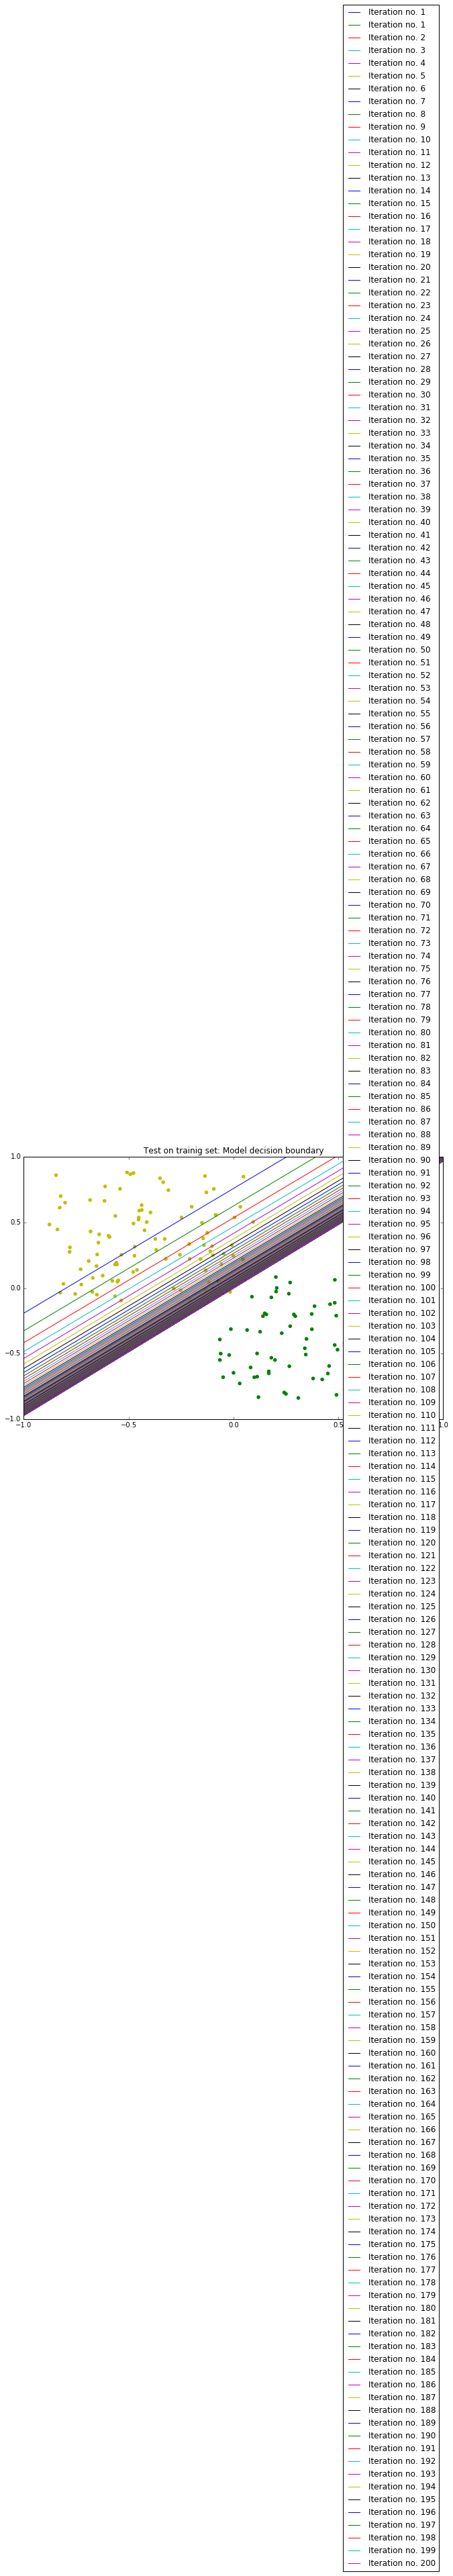

In [23]:
# evaluate with the testing set

# define a weight-plotting function

def weight_plot(it_id, mod_weight, x, y):
    #line slope
    b = mod_weight[0] / (-1 * mod_weight[1])
    #line intercept
    a = mod_weight[2]
    
    x_val = x
    y_val = [(a + b * x) for x in x_val]
    zip_vals = np.array(zip(x_val, y_val))
    
    if it_id is not None:
        pl_name = 'Iteration no. ' + str(it_id)
    else:
        pl_name = 'Initial state'
    print pl_name
    plt.plot(zip_vals[:, 0], zip_vals[:, 1], label = pl_name)

# for each iteration, plot the weights

def show_progress(its, new_weights, pl_no):
    
    fig = plt.gcf()
    fig.set_size_inches(14, 7)
    
    plt.title('Test on trainig set: Model decision boundary')
    plot_data(testing_m)
    
    axes = plt.gca()
    
    xlim = axes.get_xlim()
    ylim = axes.get_ylim()
    
    #and show what happens at each iteration
    
    weight_plot(its[0], new_weights[0], xlim, ylim)
    
    for i, alpha in zip(range(1, len(its)), np.linspace(0.05, 0.2, len(its))):
        weight_plot(i, new_weights[i], xlim, ylim)
    
    weight_plot(its[-1], new_weights[-1], xlim, ylim)
    
    #organize the plots
    
    frame = axes.get_position()
    
    axes.set_position([frame.x0, frame.y0, frame.width * 0.8, frame.height])
    
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    
show_progress(iterations_mllib, weights_mllib, 10)

Now, we can show what is a good number of iterations for trainig the logistic regression model, by plotting the accuracy as a function of number of iterations.

ValueError: x and y must have same first dimension

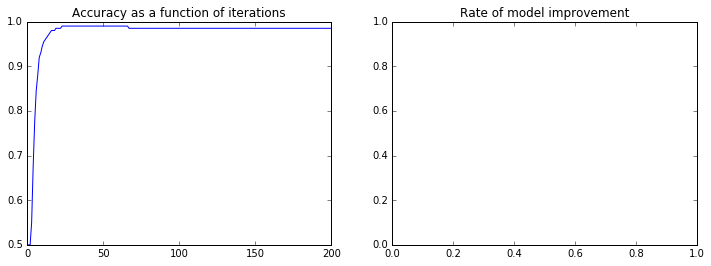

In [33]:
import matplotlib.pyplot as plt


#Evaluate the accuracy

def accurate(mod_weights):
    mod = LogisticRegressionModel(mod_weights[:-1], mod_weights[-1], 2, 2)
    
    #consider both predictions and result
    
    rdd_pred_labels = mod.predict(rdd_test_features)
    return rdd_pred_labels.zip(rdd_labels).map(lambda x: 1.0 if x[0]==x[1] else 0.0).mean()

# plot the accuracy

fig = plt.gcf()
fig.set_size_inches(12,4)
results = [accurate(mod_weights) for mod_weights in weights_mllib]
plt.subplot(1, 2, 1)
plt.title('Accuracy as a function of iterations')
plt.plot(iterations_mllib, results)

# Evaluate the improvement rate

def model_improvements(old_weights, new_weights):
    w_imp = np.array(old_weights) - np.array(new_weights)
    return np.linalg.norm(w_imp)

# plot the improvement rate too

improvements = [model_improvements(old_weights, new_weights) for old_weights, new_weights in zip(weights_mllib[:-1], weights_mllib[1:])]
plt.subplot(1, 2, 2)
plt.title('Rate of model improvement')
plt.plot(iterations_mllib, improvements)

These results suggest that the optimal number of iterations for training this regression is 10, because it's enough for the results to converge.

In [61]:
## Run Scripts, S3 Sync

<a name="HW11.4"><h2 style="color:darkblue"> HW11.4 SVMs  </h2>
[Back to Table of Contents](#TOC)

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 

__HW11.4.1 [Optional]__ Derive and Implement in Spark a weighted hard linear svm classification learning algorithm. Feel free to use the following notebook as a starting point
SVM Notebook.
Evaluate your homegrown weighted linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3 (linearly separable dataset). Report misclassification error (1 - Accuracy) and how many iterations does it took to converge? How many support vectors do you end up with?
Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.
__HW11.4.2 [Optional]__ Repeat HW11.4.2 using a soft SVM and a nonlinearly separable datasets. Compare the error rates that you get here with the error rates you achieve using MLLib's soft SVM. Report the number of support vectors in both cases (may not be available the MLLib implementation).

In [65]:
## Code goes here

In [66]:
## Drivers & Runners

In [67]:
## Run Scripts, S3 Sync

<a name="HW11.5"><h2 style="color:darkgreen"> HW11.5  [OPTIONAL] Distributed Perceptron algorithm. </h2>
[Back to Table of Contents](#TOC)

Using the following papers as background:
http://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//pubs/archive/36266.pdf

https://www.dropbox.com/s/a5pdcp0r8ptudgj/gesmundo-tomeh-eacl-2012.pdf?dl=0

http://www.slideshare.net/matsubaray/distributed-perceptron 

Implement each of the following flavors of perceptron learning algorithm:

1. Serial (All Data): This is the classifier returned if trained serially on all the available data.  On a single computer for example (Mistake driven)
2. Serial (Sub Sampling): Shard the data, select one shard randomly and train serially. 
3. Parallel (Parameter Mix): Learn a perceptron locally on each shard: 
Once learning is complete combine each learnt percepton using a uniform weighting
4. Parallel (Iterative Parameter Mix) as described in the above papers.

In [71]:
## Code goes here

In [72]:
## Drivers & Runners

In [73]:
## Run Scripts, S3 Sync

<a name="HW11.6"><h2 style="color:darkblue"> HW11.6 [OPTIONAL: consider doing this in a group]  Evalution of perceptron algorihtms on PennTreeBank POS corpus </h2>
[Back to Table of Contents](#TOC)

Reproduce the experiments reported in the following paper:

*Prediction with MapReduce - Andrea Gesmundo and  Nadi Tomeh*

http://www.aclweb.org/anthology/E12-2020 

These experiments focus on the prediction accuracy on a part-of-speech
(POS) task using the PennTreeBank corpus. They use sections 0-18 of the Wall
Street Journal for training, and sections 22-24 for testing.
 


<a name="HW11.7"><h2 style="color:darkgreen"> HW11.7 [OPTIONAL: consider doing this in a group] Kernal Adatron  </h2>
[Back to Table of Contents](#TOC)

Implement the Kernal Adatron in Spark (contact Jimi for details)


<a name="HW11.8"><h2 style="color:darkgreen"> HW11.8 [OPTIONAL] Create an animation of gradient descent for the Perceptron learning or for the logistic regression </h2>
[Back to Table of Contents](#TOC)
    
Learning with the following 3 training examples. Present the progress in terms of the 2 dimensional input space in terms of a contour plot and also in terms of the 3D surface plot. See Live slides for an example.
[Back to Table of Contents](#TOC)
Here is a sample training dataset that can be used:
-2, 3, +1
-1, -1, -1
2, -3, 1

Please feel free to use 
 + R (yes R!)
 + d3
 + https://plot.ly/python/
 + Matplotlib

I am happy for folks to collaborate on HW11.8 also.

It would be great to get the 3D surface and contours lines (with solution region and label normalized data) all in the same graph




In [77]:
## Code goes here

In [78]:
## Drivers & Runners

In [79]:
## Run Scripts, S3 Sync

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HOWEWORK --------</h2></div></center>